<a href="https://colab.research.google.com/github/AnyaRajan/EEG_Big_Data_Analysis/blob/main/EEG_Big_Data_Analysis%20/Prediction%20of%20stay%20and%20leave/%20Stay_Leave_Predictor_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imblearn tensorflow scikit-learn pandas

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import classification_report

In [ ]:
df = pd.read_csv('All_epochs_combined_MN.csv')


In [ ]:
X = df.drop(columns=['Decision', 'Reward','Tree number','Cumulative reward per tree'])  # Features
y = df['Decision']  # Target


In [ ]:
le_trait = LabelEncoder()
X['trait_anx_level'] = le_trait.fit_transform(X['trait_anx_level'])

In [ ]:
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)


In [ ]:

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

In [ ]:
# Initialize Random Forest classifier with balanced class weights
model = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=200,
    max_depth=10,
    random_state=42
)

In [ ]:
#Cross-validation with F1 scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=cv, scoring='f1')
print(f'Cross-validated F1 scores: {cv_scores}')
print(f'Mean F1 score: {cv_scores.mean():.4f}')


Cross-validated F1 scores: [0.81496711 0.80696074 0.82117081 0.81136738 0.82576383]
Mean F1 score: 0.8160


In [ ]:

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.2,
    stratify=y_resampled,
    random_state=42
)


In [ ]:
# Train the model
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

In [ ]:
# Predict on test set
y_pred = model.predict(X_test)

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))


Classification Report:
              precision    recall  f1-score   support

       leave       0.81      0.87      0.84      1292
        stay       0.86      0.79      0.82      1291

    accuracy                           0.83      2583
   macro avg       0.83      0.83      0.83      2583
weighted avg       0.83      0.83      0.83      2583



In [ ]:
# Display top 10 important features
importances = pd.Series(model.feature_importances_, index=X.columns)
print("\nTop 10 Important Features:")
print(importances.sort_values(ascending=False).head(10))


Top 10 Important Features:
Reaction time      0.039608
En_IO              0.037369
trait_anx_level    0.031678
En_F7              0.027046
En_F8              0.019934
En_Fp2             0.017457
En_Fp1             0.015547
P4_theta_alpha     0.015249
Pz_theta_alpha     0.014181
F3_Fz_AFC          0.013458
dtype: float64


In [ ]:
# Optional: Hyperparameter tuning with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}


In [ ]:
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

In [ ]:
random_search.fit(X_train, y_train)
print("\nBest hyperparameters found:")
print(random_search.best_params_)



Best hyperparameters found:
{'n_estimators': 300, 'min_samples_leaf': 2, 'max_depth': 15}


In [ ]:
# Retrain Random Forest with best hyperparameters
best_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_leaf=2,
    max_depth=15,
    class_weight='balanced',
    random_state=42
)

In [ ]:
best_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, n_estimators=300, random_state=42)

In [ ]:
# Predict on test set
y_pred_best = best_model.predict(X_test)

In [ ]:
# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_best, target_names=le_target.classes_))


              precision    recall  f1-score   support

       leave       0.84      0.90      0.87      1292
        stay       0.89      0.83      0.86      1291

    accuracy                           0.86      2583
   macro avg       0.87      0.86      0.86      2583
weighted avg       0.87      0.86      0.86      2583



In [ ]:
# Feature importances
importances = pd.Series(best_model.feature_importances_, index=X.columns)
print("\nTop 10 Important Features:")
print(importances.sort_values(ascending=False).head(10))


Top 10 Important Features:
Reaction time      0.028120
En_IO              0.027770
trait_anx_level    0.022251
En_F7              0.021455
En_F8              0.016616
En_Fp2             0.016402
P4_theta_alpha     0.013524
F3_Fz_AFC          0.012401
En_Fp1             0.012369
F3_Fz_TFC          0.011706
dtype: float64


<ipython-input-30-2487e095293a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


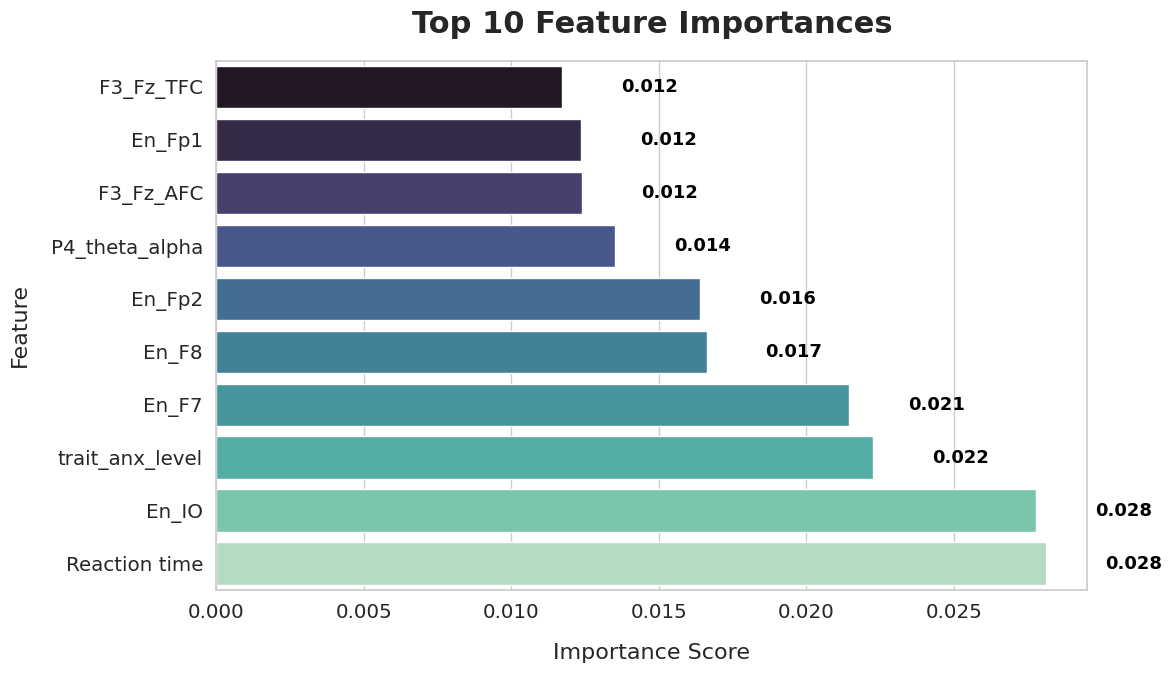

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract top 10 features
importances_top10 = importances.sort_values(ascending=False).head(10).sort_values(ascending=True)

plt.figure(figsize=(12, 7))
sns.set(style="whitegrid", font_scale=1.3)

barplot = sns.barplot(
    x=importances_top10.values,
    y=importances_top10.index,
    palette="mako"
)

plt.title('Top 10 Feature Importances', fontsize=22, weight='bold', pad=20)
plt.xlabel('Importance Score', fontsize=16, labelpad=15)
plt.ylabel('Feature', fontsize=16, labelpad=15)

# Annotate bars with importance values
for i, v in enumerate(importances_top10.values):
    barplot.text(v + 0.002, i, f'{v:.3f}', color='black', va='center', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

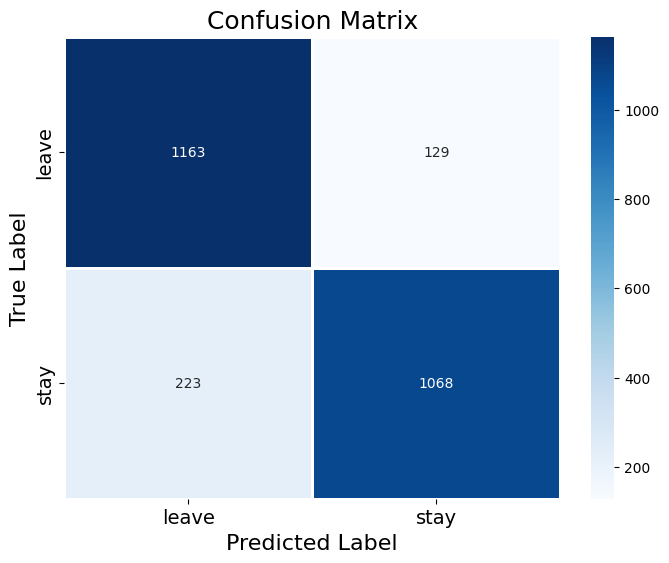

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

# Get the class labels (e.g., ['leave', 'stay'])
labels = le_target.classes_

# Plotting a pretty confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, linewidths=2, linecolor='white')
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.title('Confusion Matrix', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


In [ ]:
y_prob = best_model.predict_proba(X_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

print(f"AUC-ROC Score: {auc_score:.3f}")

AUC-ROC Score: 0.943


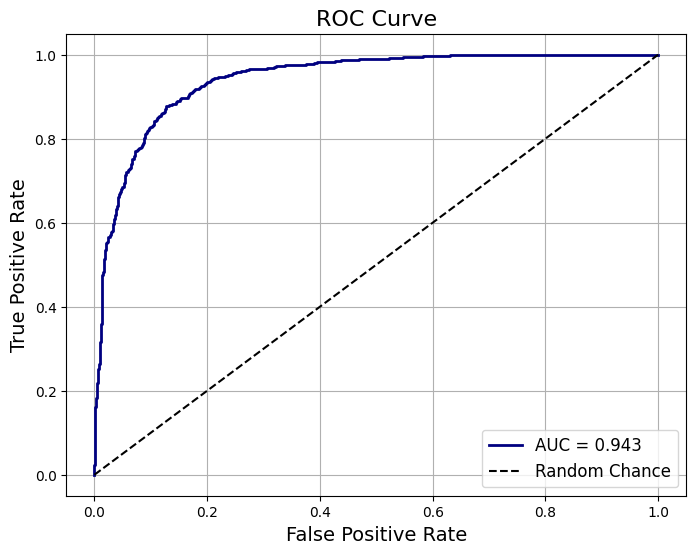

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', color='navy', linewidth=2)
plt.plot([0,1], [0,1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.show()

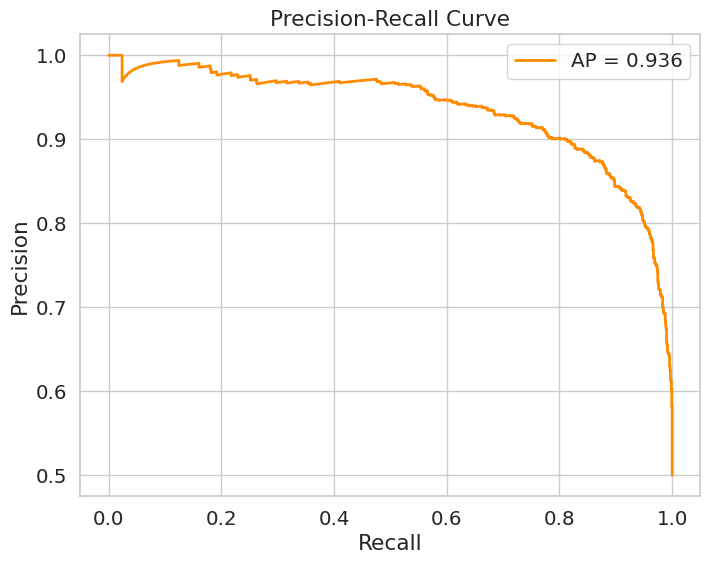

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_prob)
ap_score = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'AP = {ap_score:.3f}', color='darkorange', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


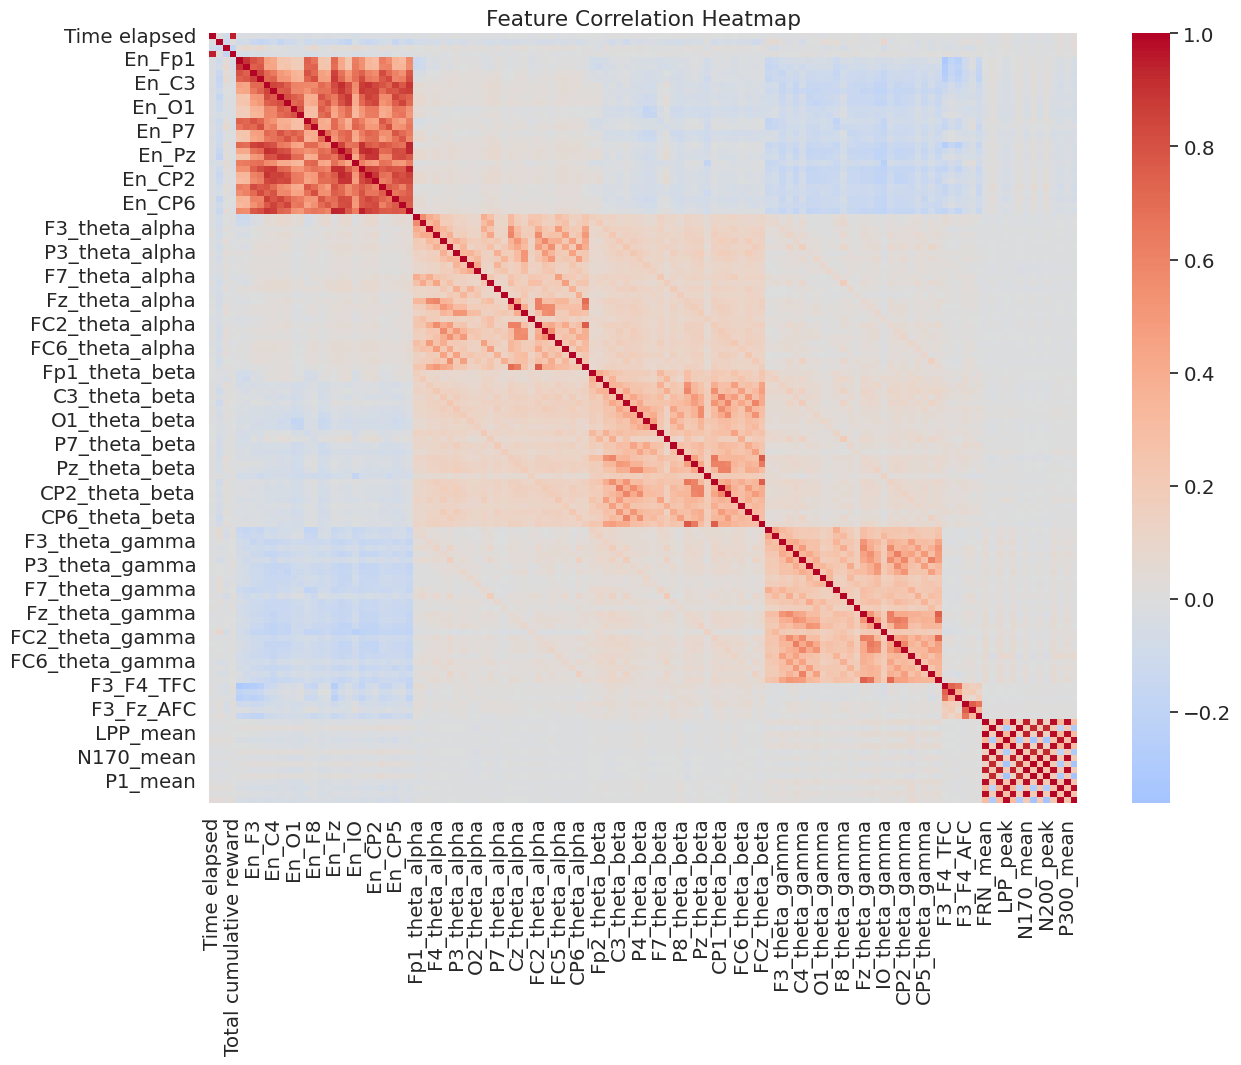

In [ ]:
corr = X.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()


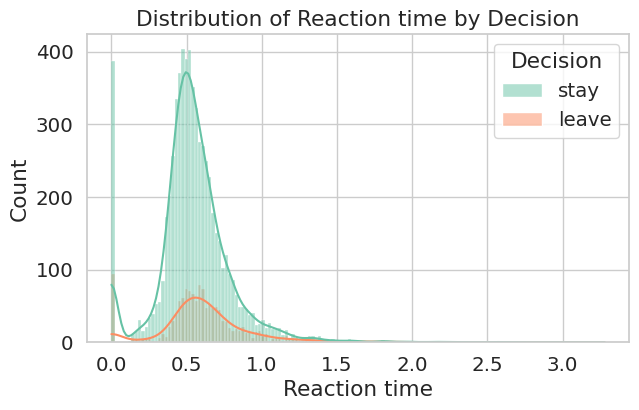

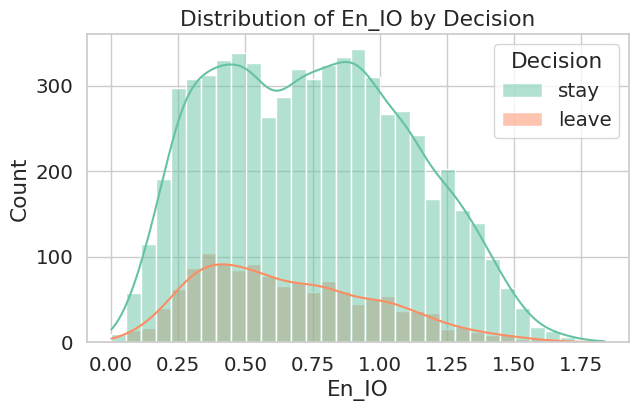

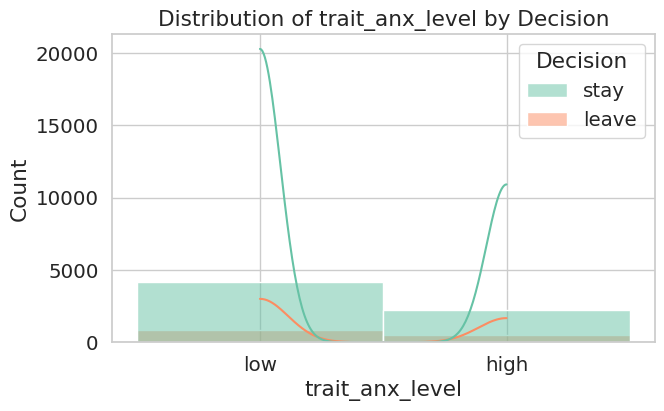

In [ ]:
top_features = importances.sort_values(ascending=False).head(3).index
for feature in top_features:
    plt.figure(figsize=(7,4))
    sns.histplot(data=df, x=feature, hue='Decision', kde=True, palette='Set2')
    plt.title(f'Distribution of {feature} by Decision')
    plt.show()


In [ ]:
# If not already done:
from sklearn.preprocessing import LabelEncoder
df['trait_anx_level'] = LabelEncoder().fit_transform(df['trait_anx_level'])

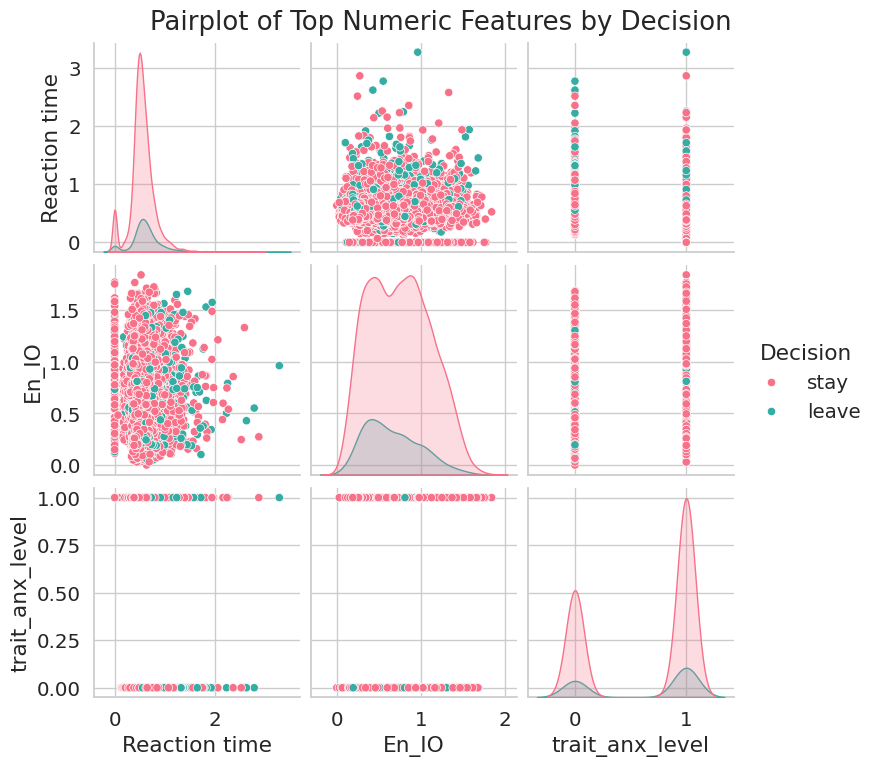

In [ ]:
import numpy as np

# Get only numeric columns from your DataFrame
numeric_features = [f for f in top_features if np.issubdtype(df[f].dtype, np.number)]

import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df, vars=numeric_features, hue='Decision', palette='husl')
plt.suptitle('Pairplot of Top Numeric Features by Decision', y=1.02)
plt.show()


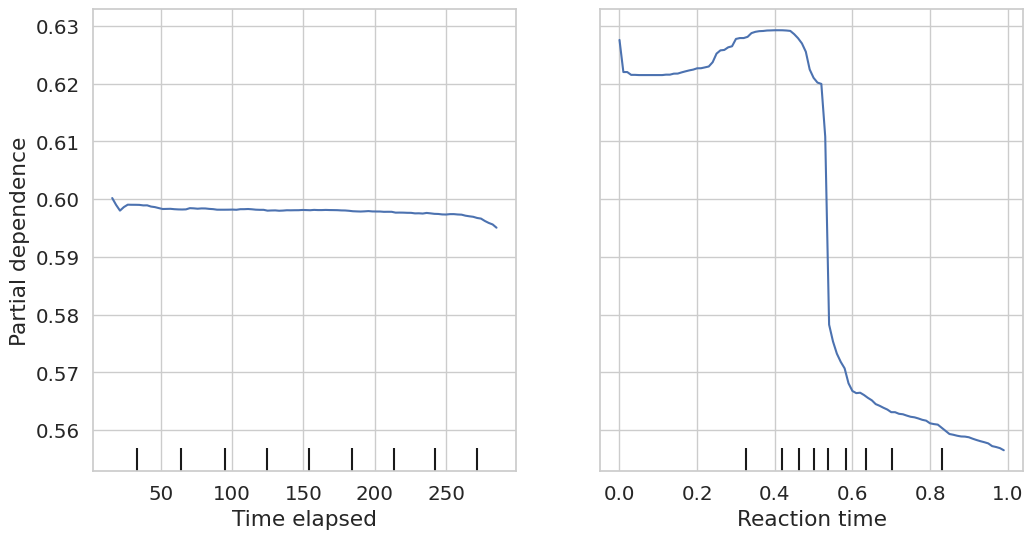

In [ ]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Suppose 'model' is your trained model, 'X' is your input features, and 'features' is a list of feature names or indices
features = ['Time elapsed', 'Reaction time']  # Example features

fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(model, X, features, ax=ax)
plt.show()
